In [1]:
using QuadGK
using JuMP, OSQP
using Ipopt
using Statistics
using DifferentialEquations
using BoundaryValueDiffEq
using LinearAlgebra
using Plots

[FORMULA PLACEHOLDER]

In [2]:
function matern_kernel_0p5(t_i, t_j; sigma, rho)
    d = abs(t_i - t_j)
    return sigma^2 * exp(-d / rho)
end

function integrated_matern_kernel_0p5(t_i, t_j; sigma, rho)
    s = t_i - t_j
    d = abs(s)
    base = rho * (sigma^2) 
    if s < 0
        return base * (exp(-d / rho) - exp(-t_j / rho))
    else
        return base * (2 - exp(-d / rho) - exp(-t_j / rho))
    end
end

function matrices_matern_kernel_0p5(t, s; sigma, rho)
    K = [matern_kernel_0p5(t[i], s[j]; sigma, rho) for i in 1:length(t), j in 1:length(s)]
    K_tilde = [integrated_matern_kernel_0p5(t[i], s[j]; sigma, rho) for i in 1:length(t), j in 1:length(s)]
    return K, K_tilde
end

# The function is defined in "src/neoclassical_growth_baseline.jl"
function neoclassical_growth_baseline(a, delta, r, sigma_crra, k_0, T_max;dt=0.001)
    k_ss = ((delta + r) / a)^(1 / (a - 1))
    c_ss = a * k_ss^a - delta * k_ss

    
    function ode!(dy, y, p, t)
        k, c = y
        dy[1] = k^a - c - delta * k
        dy[2] = (c / sigma_crra) * (a * k^(a - 1) - r - delta)
    end
    
    function bc!(residual, y, p, t)
        residual[1] = y[1][1] - k_0
        residual[2] = y[end][1] - k_ss
    end
    
    tspan = (0.0, T_max)
    initial_guess = [k_ss, c_ss]
    bvp = BVProblem(ode!, bc!, initial_guess, tspan)
    
    return solve(bvp, MIRK4(); dt)
end

neoclassical_growth_baseline (generic function with 1 method)

Defining the parameters

In [3]:
a = 1/3
delta = 0.1
rho_hat = 0.11
k_0 = 1.0
nu = 0.5
sigma = 1.0
rho = 10.0
train_T = 40.0
train_points = 41
test_T = 50.0
test_points = 100
baseline_T = 60.0
lambda_p = 0.0
verbose = false
tol = 1e-8
dual_inf_tol = 1e-8
constr_viol_tol = 1e-8
max_iter = 2000;

Traning and testing grids

In [4]:
train_data = range(0, train_T, length=train_points)
test_data = range(0, test_T, length=test_points);

Constructing kernel matrices 

In [5]:
K, K_tilde = matrices_matern_kernel_0p5(train_data, train_data; sigma, rho)
K = Symmetric((K + K')/2) # symmetric since train_data both arguments. K_tilde not symmetric
N = length(train_data);

Speicfying the JuMP model, variables, and objective

In [6]:
# Create JuMP model with Ipopt (non-convex problem)
model = Model(Ipopt.Optimizer)
if !verbose
    set_silent(model)
end
set_attribute(model, "tol", tol)
set_attribute(model, "dual_inf_tol", dual_inf_tol)
set_attribute(model, "constr_viol_tol", constr_viol_tol)
set_attribute(model, "max_iter", max_iter)

@variable(model, alpha_mu[1:N])
@variable(model, alpha_c[1:N])
@variable(model, alpha_k[1:N])
@variable(model, c_0 >= 0, start = k_0^a - delta * k_0)
@variable(model, mu_0 >= 0, start = k_0^a - delta * k_0)

@objective(model, Min,
    dot(alpha_mu, K * alpha_mu) +
    dot(alpha_k,  K * alpha_k)
);    

Defining auxiliary variables, nonlinear expressions, and system constraints; solving the model

In [7]:
# Building blocks to preserve sparsity in JuMP's nonlinear model
# Create auxiliary variables for linear transformations of alpha coefficients
@variable(model, dk_dt[1:N])      # dk_dt = K * alpha_k (derivative via kernel)
@variable(model, dmu_dt[1:N])     # dmu_dt = K * alpha_mu (derivative via kernel)
@variable(model, k_tilde[1:N])    # k_tilde = K_tilde * alpha_k (integrated kernel)
@variable(model, mu_tilde[1:N])   # mu_tilde = K_tilde * alpha_mu (integrated kernel)
@variable(model, c_tilde[1:N])    # c_tilde = K_tilde * alpha_c (integrated kernel)

# Linear equality constraints define these auxiliary variables
@constraint(model, dk_dt .== K * alpha_k)
@constraint(model, dmu_dt .== K * alpha_mu)
@constraint(model, k_tilde .== K_tilde * alpha_k)
@constraint(model, mu_tilde .== K_tilde * alpha_mu)
@constraint(model, c_tilde .== K_tilde * alpha_c)

# Nonlinear expressions for state and control variables
@NLexpression(model, mu[i=1:N], mu_0 + mu_tilde[i])
@NLexpression(model, c[i=1:N],  c_0 + c_tilde[i])
@NLexpression(model, k[i=1:N],  k_0 + k_tilde[i])

# System constraints (resource, Euler, shadow price)
@NLconstraint(model, [i=1:N], dk_dt[i] == k[i]^a - delta * k[i] - c[i])
@NLconstraint(model, [i=1:N], dmu_dt[i] == -mu[i] * (a * k[i]^(a-1) - delta - rho_hat))
@NLconstraint(model, [i=1:N], mu[i] * c[i] == 1.0)

println("Solving Neoclassical Growth Matern with N=$N")
optimize!(model)

Solving Neoclassical Growth Matern with N=41

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Extracting solutions and evaluating on the test grid

In [8]:
alpha_c_val = value.(alpha_c)
alpha_k_val = value.(alpha_k)
c_0_val = value(c_0)
solve_time_sec = solve_time(model)

# Kernel solution interpolator
function kernel_solution(t_test)
    _, K_tilde_test = matrices_matern_kernel_0p5(t_test, train_data; sigma, rho)
    c_test = c_0_val .+ K_tilde_test * alpha_c_val
    k_test = k_0 .+ K_tilde_test * alpha_k_val
    return k_test, c_test
end

# Baseline solution
sol_baseline = neoclassical_growth_baseline(a, delta, rho_hat, 1.0, k_0, baseline_T)

function baseline_solution(t_test)
    sol = sol_baseline.(t_test)
    k_baseline = [s[1] for s in sol]
    c_baseline = [s[2] for s in sol]
    return k_baseline, c_baseline
end;

# Evaluate on test data
k_baseline, c_baseline = baseline_solution(test_data)
k_test, c_test = kernel_solution(test_data)

k_rel_error = abs.(k_baseline .- k_test) ./ k_baseline
c_rel_error = abs.(c_baseline .- c_test) ./ c_baseline

println("solve_time(s) = $solve_time_sec, E(|rel_error(k)|) = $(mean(k_rel_error)), E(|rel_error(c)|) = $(mean(c_rel_error))")

solve_time(s) = 2.217989206314087, E(|rel_error(k)|) = 0.0004391826666156981, E(|rel_error(c)|) = 0.000304995693303921


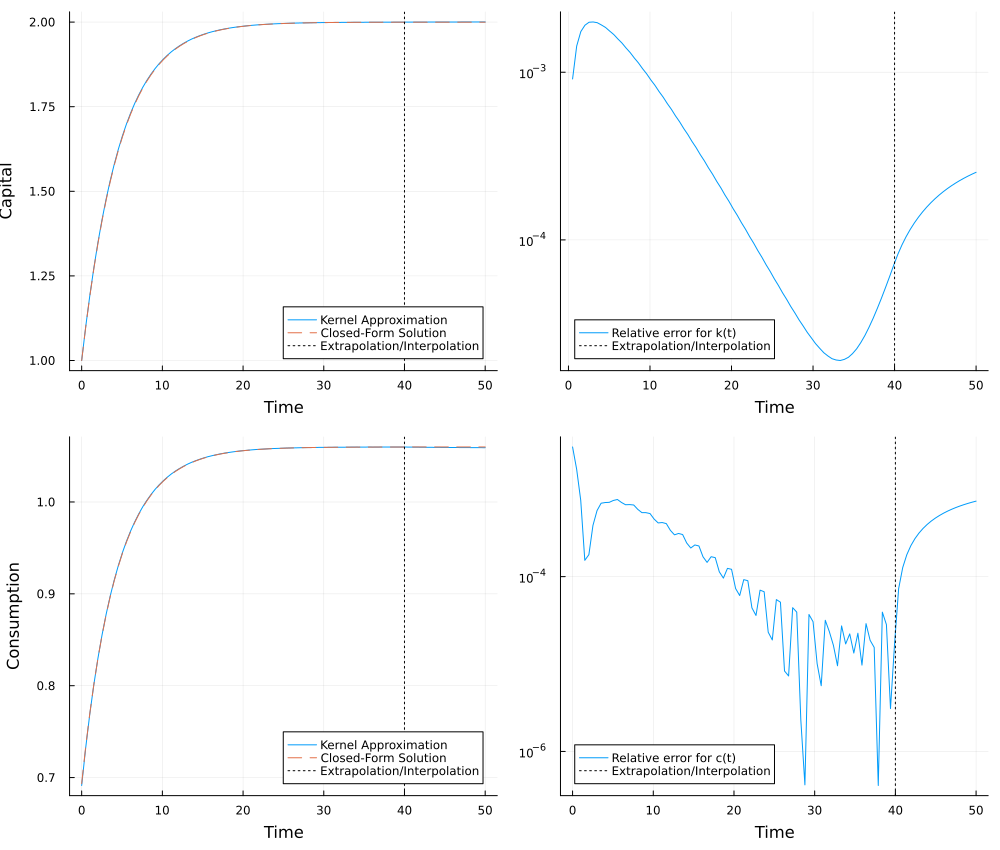

In [9]:
p1 = plot(
    test_data,
    k_test,
    label = "Kernel Approximation",
    xlabel = "Time",
    ylabel = "Capital",
    legend = :bottomright,
)
plot!(
    test_data,
    k_baseline,
    linestyle = :dash,
    label = "Closed-Form Solution",
)

# Since the relative error of k is 0 at t = 1, it breaks the log y scale, and so is omitted
eps = 1e-6
k_rel_plot = max.(k_rel_error, eps)
p2 = plot(
    test_data[2:end],
    k_rel_error[2:end],
    label  = "Relative error for k(t)",
    xlabel = "Time",
    yscale = :log10,
    legend = :bottomleft,
)

p3 = plot(
    test_data,
    c_test,
    label = "Kernel Approximation",
    xlabel = "Time",
    ylabel = "Consumption",
    legend = :bottomright,
)
plot!(
    test_data,
    c_baseline,
    linestyle = :dash,
    label = "Closed-Form Solution",
)

p4 = plot(
    test_data,
    c_rel_error,
    label  = "Relative error for c(t)",
    xlabel = "Time",
    yscale = :log10,
    legend = :bottomleft,
)

for ax in (p1, p2, p3, p4)
    vline!(
        ax,
        [40],
        linestyle = :dot,
        color = :black,
        label = "Extrapolation/Interpolation",
    )
end

plot(p1, p2, p3, p4, layout = (2, 2), size = (1000, 850))